In [1]:
import openai
from openai import OpenAI
import os
openai.api_key = os.getenv("OPENAI_API_KEY")

In [3]:
# import sys
# print(sys.executable)
!pip show langchain-community

Name: langchain-community
Version: 0.3.20
Summary: Community contributed LangChain integrations.
Home-page: 
Author: 
Author-email: 
License: MIT
Location: /Users/kassandramadulka/Documents/github/articlewriter_langgraph/articlewriter/lib/python3.10/site-packages
Requires: aiohttp, dataclasses-json, httpx-sse, langchain, langchain-core, langsmith, numpy, pydantic-settings, PyYAML, requests, SQLAlchemy, tenacity
Required-by: 


In [4]:
# from langchain_openai import ChatOpenAI
from langchain_community.chat_models import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import OpenAIEmbeddings
from langgraph.graph import START, MessagesState, StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.types import interrupt, Command
from langgraph.constants import Send

# from langchain_pinecone import PineconeVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.schema import HumanMessage, AIMessage, BaseMessage

from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import MessagesPlaceholder
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from typing import Dict, List, Optional, Union
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, trim_messages, BaseMessage


from typing import Sequence, Literal
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
import pandas as pd
import random
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder

# from langchain.chains import StateGraph
# from langchain.memory import MemorySaver
import random
import json
import getpass

os.environ["MERMAID_TIMEOUT"] = "60"

embeddings = OpenAIEmbeddings()

llm = ChatOpenAI(model="gpt-4o", temperature=0.7)

/var/folders/n1/0x5hm6k96zg547470kdfm8vw0000gn/T/ipykernel_94761/245099123.py:46: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="gpt-4o", temperature=0.7)


In [3]:
# create analysts subgraph

class Analyst(BaseModel):
    name: str = Field(..., description="name of analyst")
    role: str = Field(..., description = "role of the analyst in the context of the topic")
    description: str = Field(..., description="description of the analyst focus, concerns, motives")

    @property
    def persona(self)-> str:
        return f"Name {self.name}\nRole: {self.role}\n Description: {self.description}"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(..., description="list of analysts and their roles and descriptions")

class GenerateAnalystsState(BaseModel):
    topic: str
    max_analysts: int = 3
    human_analyst_feedback: Optional[str] = None
    analysts: Optional[Perspectives] = None


    

In [4]:
from enum import Enum
class NodeName(str, Enum):
    END= END
    CREATE_ANALYSTS = "create_analysts"
    HUMAN_FEEDBACK = "human_feedback"
    START = START
    SAVE_INTERVIEW = "save_interview"
    GENERATE_QUESTION = "generate_question"
    CONDUCT_INTERVIEW = "conduct_interview"
    WRITE_REPORT = "write_report"
    WRITE_INTRODUCTION = "write_introduction"
    WRITE_CONCLUSION = "write_conclusion"
    FINALIZE_REPORT = "finalize_report"
    SEARCH_WEB = "search_web"
    SEARCH_WIKIPEDIA = "search_wikipedia"
    ANSWER_QUESTION = "answer_question"
    WRITE_SECTION = "write_section"

    
analyst_instructions = """
You are tasked with creating a set of analyst personas. Follow these instructions carefully:
1. First review the research topic:
{topic}
2. Estimate any editorial feedback that been optionally provided to guide creation of the analysts:
{human_analyst_feedback}
3. Determine the most interesting themes based upon documents and/or feedback above
4. Pick the top {max_analysts} themes.
5. Assign one analyst to each theme
"""

def create_analysts(state: GenerateAnalystsState):
    """Generate the analysts personas"""

    topic = state.topic
    max_analysts = state.max_analysts
    human_analyst_feedback = state.human_analyst_feedback

    structured_llm = llm.with_structured_output(Perspectives)
    system_msg = analyst_instructions.format(topic=topic, human_analyst_feedback= human_analyst_feedback, max_analysts=max_analysts)

    analysts = structured_llm.invoke([
        SystemMessage(content=system_msg),
    ]+ [HumanMessage(content='Generate the set of analysts')])

    print(analysts)

    state.analysts = analysts

    return state

    

def human_feedback(state: GenerateAnalystsState):
    """ask for human feedback for analysts"""

    human_feedback = interrupt("Please input any feedback for the analysts: ")
    print(f"human feedback: {human_feedback}")

    state.human_analyst_feedback = human_feedback

    if human_feedback:
        return Command(update={"human_analyst_feedback": human_feedback}, goto="create_analysts")
    else:
        return Command(update={"human_analyst_feedback": None}, goto=END)

    

In [5]:
builder = StateGraph(GenerateAnalystsState)
builder.add_node(NodeName.CREATE_ANALYSTS, create_analysts)
builder.add_node(NodeName.HUMAN_FEEDBACK, human_feedback)

builder.add_edge(NodeName.START, NodeName.CREATE_ANALYSTS)
builder.add_edge(NodeName.CREATE_ANALYSTS, NodeName.HUMAN_FEEDBACK)
builder.add_conditional_edges(
        NodeName.HUMAN_FEEDBACK,
        lambda state: NodeName.CREATE_ANALYSTS if (state.human_analyst_feedback is not None) else NodeName.END,
        [NodeName.CREATE_ANALYSTS, NodeName.END]
    )

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)


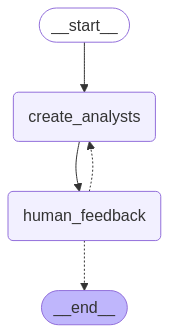

In [9]:
display(Image(builder.compile(checkpointer=memory).with_config(
    run_name="Create Analysts", mermaid_timeout=60
).get_graph().draw_mermaid_png()))


In [10]:
from time import sleep
topic = "best food to eat in NYC"
thread = {"configurable":{"thread_id":"1"}}

graph.invoke({"topic": topic},
        thread,
        stream_mode="updates"
    )

while graph.get_state(thread).next: #need while loop if there is feedback
        graph_state = graph.get_state(thread)
        interrupt_value = graph_state.tasks[0].interrupts[0].value

        # Occasionally, the previous print statement is not visible in the console.
        sleep(0.5)

        human_feedback_text = input(interrupt_value) #input stored here
        print(f"\nAgent Response: {human_feedback_text}\n\n")

        # config["callbacks"] = [MLflowTracerOverrideWarnings()]
        graph.invoke(Command(resume=human_feedback_text), config=thread)

analysts=[Analyst(name='Gastronomic Historian', role='Cultural Analyst', description="Focused on the historical and cultural significance of various foods found in NYC. This analyst explores how immigrant communities have influenced the city's culinary landscape, examining traditional dishes and their evolution over time. Their motive is to provide a rich, historical context to the food scene in NYC."), Analyst(name='Trend Tracker', role='Contemporary Food Analyst', description="Examines the current food trends in NYC, including popular new restaurants, viral food items, and emerging culinary movements. This analyst is concerned with what's hot and trending in the city's dynamic food scene, aiming to identify what makes certain foods or dining experiences popular at any given time."), Analyst(name='Health-Conscious Foodie', role='Nutritional Analyst', description='Focuses on the health aspects of foods available in NYC. This analyst evaluates the nutritional value of popular dishes, se

Please input any feedback for the analysts:  



Agent Response: 


human feedback: 


In [7]:
graph.get_state(thread).values['analysts'].analysts

[Analyst(name='Culinary Historian Emma', role='Culinary Historian', description="Emma delves into the historical roots of New York City's diverse culinary scene. She is interested in how traditional dishes from immigrant communities have become iconic NYC foods. Her focus is on understanding the evolution of food culture in the city and how past influences shape current trends."),
 Analyst(name='Local Foodie Alex', role='Local Foodie', description="Alex is a passionate local food enthusiast who is always on the hunt for the best and most authentic food experiences in New York City. His focus is on uncovering hidden gems and iconic eateries that offer a true taste of the city's diverse food offerings. Alex is driven by a desire to share these finds with both locals and tourists who want to experience NYC's culinary landscape like a local."),
 Analyst(name='Health-Conscious Nutritionist Sarah', role='Health-Conscious Nutritionist', description="Sarah analyzes the best food options in NYC

In [11]:
import operator

class InterviewState(BaseModel):
    max_num_turns: int = 10
    context: Annotated[list[AnyMessage], add_messages] = []
    analyst: Analyst
    interview: str = ""
    sections: Annotated[list[AnyMessage], add_messages] = []
    messages: Annotated[list[AnyMessage], add_messages] = []

class SearchQuery(BaseModel):
    search_query: str = Field(..., description="search query for retrieval")


question_instructions = """
You are ana analyst tasked with interviewing an expert to learn about a specific topic. 
Your goal is to boil down interesting and specific insights related to your topic.
1. Interesting meaning insights that people will find surprising or non-obvious
2. Specific meaning insights that avoid generalities and include specific examples from the expert
This is your topic of focus and set of goals:
{goals}
Begin by introducing yourself using a name that fits your persona and then ask your questions
When you are satisfied with your understanding, complete the interview with "Thank you for your help"
Remember to stay in character throughout your response, reflecting the persona and goals provided to you
"""

def generate_question(state: InterviewState):
    analyst = state.analyst
    messages = state.messages

    sys_msg = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=sys_msg)]+messages)

    state.messages = question

    return state

In [ ]:
from tavily import TavilyClient
api_key = os.getenv("TAVILY_API_KEY")
client = TavilyClient(api_key)

In [13]:
from langchain_community.tools import DuckDuckGoSearchResults

from langchain_community.tools import DuckDuckGoSearchResults
import requests
from bs4 import BeautifulSoup

search = DuckDuckGoSearchResults(source="news") #backend="news"

sd_test = search.invoke("Best restaurants NYC")
# Step 1: Perform the Search
search = DuckDuckGoSearchResults(source="news")
results = search.invoke("Best restaurants NYC")

# Step 2: Extract URLs from Results
urls = [entry.split("link: ")[1].split(",")[0] for entry in results.split("title:") if "link:" in entry]

# Step 3: Scrape Content from Each URL
def scrape_url(url):
    try:
        headers = {"User-Agent": "Mozilla/5.0"}
        response = requests.get(url, headers=headers, timeout=5)
        response.raise_for_status()

        soup = BeautifulSoup(response.text, "html.parser")
        title = soup.title.string if soup.title else "No Title"
        paragraphs = soup.find_all("p")  # Extract paragraphs
        content = "\n".join(p.text for p in paragraphs[:5])  # Limit to first 5 paragraphs

        return {"url": url, "title": title, "content": content}
    
    except Exception as e:
        return {"url": url, "error": str(e)}

# Step 4: Scrape Each URL
scraped_data = [scrape_url(url) for url in urls]

# Print the scraped results
for data in scraped_data:
    print(f"Title: {data.get('title')}\nURL: {data['url']}\nContent:\n{data.get('content', 'No content extracted.')}\n{'-'*80}")


Title: The 50 best restaurants in NYC right now: March 2025
URL: https://www.timeout.com/newyork/restaurants/100-best-new-york-restaurants
Content:
🙌Awesome, you're subscribed!
Thanks for subscribing! Look out for your first newsletter in your inbox soon!
The best of New York straight to your inbox
We help you navigate a myriad of possibilities. Sign up for our newsletter for the best of the city.
By entering your email address you agree to our Terms of Use and Privacy Policy and consent to receive emails from Time Out about news, events, offers and partner promotions.
--------------------------------------------------------------------------------
Title: 28 Best Restaurants in New York City, From Beloved Classics to Fearless Newcomers | Condé Nast Traveler
URL: https://www.cntraveler.com/gallery/best-restaurants-in-new-york-city
Content:
North AmericaChevron
United StatesChevron
New YorkChevron
New YorkChevron
The best restaurants in New York City run all the gamuts: there's the fine 

In [19]:
from langchain_community.document_loaders import WikipediaLoader
from langchain_core.messages import get_buffer_string
from langchain_community.tools.tavily_search import TavilySearchResults

search_instructions = """
You will be given a conversation between an analyst and an expert.
Your goal is to generate a well-structured query for use in retrieval and/or web-search related to the conversation.
First, analyze the full conversation
Pay particular attention to the final question posed by the analyst
Convert this final question into a well-structured web search query
"""

def search_web(state: InterviewState):
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([SystemMessage(content=search_instructions)]+state.messages)
    # Invalid input type <class 'langchain_core.prompts.chat.ChatPromptTemplate'>. Must be a PromptValue, str, or list of BaseMessages.

    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(search_query.search_query)

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    # state.context = formatted_search_docs

    return Command(update={"context":formatted_search_docs}) #state

def search_wikipedia(state: InterviewState):
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([SystemMessage(content=search_instructions)]+state.messages)

    search_docs = WikipediaLoader(query=search_query.search_query, load_max_docs=2).load()

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    # state.context = formatted_search_docs

    return Command(update={"context":formatted_search_docs}) #state

def search_duckduckgo(state: InterviewState):
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([SystemMessage(content=search_instructions)]+state.messages)

    search = DuckDuckGoSearchResults(source="news") #backend="news"

    results = search.invoke(search_query.search_query)
    urls = [entry.split("link: ")[1].split(",")[0] for entry in results.split("title:") if "link:" in entry]
    scraped_data = [scrape_url(url) for url in urls]

    # Print the scraped results
    for data in scraped_data:
        search_docs = f"Title: {data.get('title')}\nURL: {data['url']}\nContent:\n{data.get('content', 'No content extracted.')}\n{'-'*80}"



    return Command(update={"context": search_docs}) #state

    

In [20]:
answer_instructions = """
You are an expert being interviewed by an analyst.
Here is the analyst area of focus: {goals}
Your goal is to answer a question posed by the interviewer.
To answer the question, use this context: {context}
When answering questions, follow these guidelines:
        
1. Use only the information provided in the context.     
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.
3. The context contain sources at the topic of each individual document.
4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 
5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc   
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list:   
[1] assistant/docs/llama3_1.pdf, page 7  
And skip the addition of the brackets as well as the Document source preamble in your citation.
"""

def generate_answer(state: InterviewState):
    """answer question from analyst"""
    analyst = state.analyst
    messages= state.messages
    context = state.context

    sys_msg = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=sys_msg)]+messages)

    answer.name = "expert"

    return Command(update={"messages":[answer]})

def save_interview(state: InterviewState):
    """save the interview between analyst and expert"""
    print(f"saving inteview with {state.analyst}")
    
    messages = state.messages

    interview=get_buffer_string(messages)

    # state.interview = interview
    return Command(update={"interview":interview}) #state

def route_messages(state: InterviewState):
    messages = state.messages
    name = "expert"

    num_responses = len([m for m in messages if isinstance(m, AIMessage) and m.name==name])

    if num_responses >= state.max_num_turns:
        return NodeName.SAVE_INTERVIEW

    last_question = messages[-2]

    if "Thank you for your help" in last_question.content:
        return NodeName.SAVE_INTERVIEW
    else:
        return NodeName.GENERATE_QUESTION

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed
"""

def write_section(state: InterviewState):

    """ Node to answer a question """
    # Get state
    interview = state.interview
    context = state.context
    analyst = state.analyst
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    state.sections = section.content
    return state


In [21]:
# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node(NodeName.GENERATE_QUESTION, generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia) 
interview_builder.add_node("search_duckduckgo", search_duckduckgo)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, NodeName.GENERATE_QUESTION)
interview_builder.add_edge(NodeName.GENERATE_QUESTION, "search_web")
interview_builder.add_edge(NodeName.GENERATE_QUESTION, "search_wikipedia")
interview_builder.add_edge(NodeName.GENERATE_QUESTION, "search_duckduckgo")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_edge("search_duckduckgo", "answer_question")
interview_builder.add_conditional_edges(
        "answer_question", route_messages,
        [NodeName.GENERATE_QUESTION, 'save_interview']
    )
# interview_builder.add_conditional_edges("answer_question", route_messages,[NodeName.GENERATE_QUESTION,'save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")


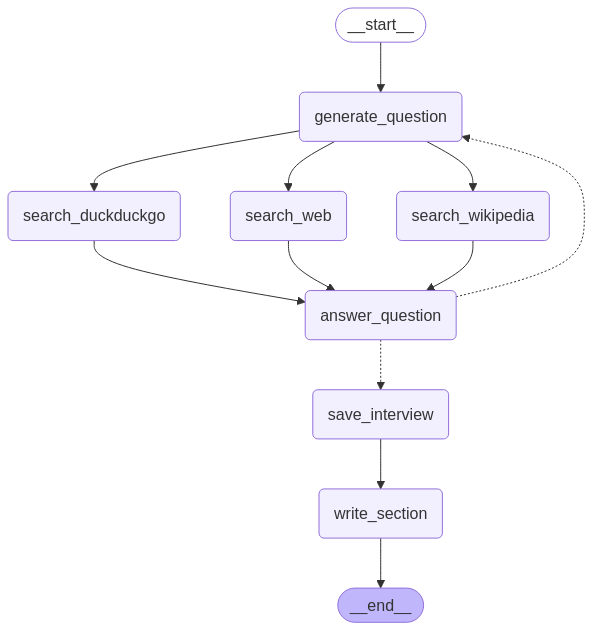

In [146]:
display(Image(interview_builder.compile(checkpointer=memory).get_graph().draw_mermaid_png()))

In [17]:
graph.get_state(thread).values

{'topic': 'best food to eat in NYC',
 'max_analysts': 3,
 'analysts': Perspectives(analysts=[Analyst(name='Gastronomic Historian', role='Cultural Analyst', description="Focused on the historical and cultural significance of various foods found in NYC. This analyst explores how immigrant communities have influenced the city's culinary landscape, examining traditional dishes and their evolution over time. Their motive is to provide a rich, historical context to the food scene in NYC."), Analyst(name='Trend Tracker', role='Contemporary Food Analyst', description="Examines the current food trends in NYC, including popular new restaurants, viral food items, and emerging culinary movements. This analyst is concerned with what's hot and trending in the city's dynamic food scene, aiming to identify what makes certain foods or dining experiences popular at any given time."), Analyst(name='Health-Conscious Foodie', role='Nutritional Analyst', description='Focuses on the health aspects of foods a

In [22]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
# thread = {"configurable": {"thread_id": "2"}}
interview = interview_graph.invoke({"analyst": graph.get_state(thread).values['analysts'].analysts[0], "messages": messages}, thread)

Markdown(interview['sections'][0].content)

saving inteview with name='Gastronomic Historian' role='Cultural Analyst' description="Focused on the historical and cultural significance of various foods found in NYC. This analyst explores how immigrant communities have influenced the city's culinary landscape, examining traditional dishes and their evolution over time. Their motive is to provide a rich, historical context to the food scene in NYC."


## Savoring History: The Culinary Tapestry of New York City

### Summary

New York City, a vibrant mosaic of cultures and traditions, has a culinary landscape profoundly shaped by waves of immigrants. Each ethnic group that arrived in the city brought with them their unique culinary traditions, which have since melded into the broader narrative of New York’s food scene. This dynamic fusion of flavors not only reflects the diverse population but also tells the rich history of the city's evolution through food.

New York’s culinary history is a testament to its role as a melting pot. The city's food scene, from the bustling streets of Manhattan to the multicultural neighborhoods of Brooklyn, is a tapestry woven with the threads of immigrant influence. For instance, Italian immigrants played a pivotal role in popularizing pizza, which transformed from its Neapolitan roots to the iconic New York slice known for its thin, foldable crust and generous toppings [1][2]. Similarly, Jewish immigrants from Eastern Europe introduced foods like bagels, pastrami, and knishes, now quintessentially associated with New York’s identity, especially in areas like the Lower East Side [3].

Moreover, the city's Chinese community has significantly influenced its culinary landscape. With dishes like chow mein and dandan noodles, these culinary offerings have evolved over time, adapting to the changing social sentiments and preferences of New Yorkers [4]. The introduction of Sichuan and Hunan cuisines in the post-Cultural Revolution era further enriched the city's food scene [4].

The influence of Latin American immigrants is also evident, with tacos, empanadas, and arepas becoming as integral to New York’s food scene as traditional American staples like hot dogs and hamburgers [3]. These diverse culinary offerings are not just about feeding people; they are about sharing cultures and creating connections through food.

What's particularly fascinating is how immigrant communities have not only introduced specific dishes but also shaped how New Yorkers dine. The concept of food markets, street vendors, and food trucks heavily draws from immigrant traditions, bringing the flavors of the world to the streets of New York [3].

In essence, New York’s food scene is a living history, where each bite tells a story of migration, adaptation, and cultural exchange. As new waves of immigrants continue to arrive, they bring with them new traditions and ideas, ensuring that the city’s culinary landscape will continue to evolve and grow richer with time.

### Sources
[1] https://www.wanderlustingk.com/travel-blog/manhattan-new-york-pizza  
[2] https://en.wikipedia.org/wiki/New_York%E2%80%93style_pizza  
[3] https://voyageny.com/the-impact-of-immigrant-communities-on-new-yorks-rich-culture/  
[4] https://scholarblogs.emory.edu/noodles/2018/07/03/evolution-of-chinese-noodles-in-nyc-a-tale-of-immigration-and-adaptation-dylan-frank/  
[5] https://www.respectbrooklyn.org/the-melting-pot-how-ethnic-groups-have-shaped-new-york-s-historical-heritage  

In [17]:
graph.get_state(thread).values['analysts'].analysts[0].persona

"Name Gastronomic Historian\nRole: Culinary Culture Analyst\n Description: Focuses on the historical and cultural evolution of food in NYC, exploring iconic dishes and the diverse culinary influences that have shaped the city's food scene over the decades. Interested in how immigrant communities have contributed to NYC's culinary landscape and what traditional foods have stood the test of time."

In [32]:
interview_graph.get_state(thread).values['messages']

[HumanMessage(content='So you said you were writing an article on best food to eat in NYC?', additional_kwargs={}, response_metadata={}, id='ca85febc-18c9-4778-86df-6f4015552b24'),
 AIMessage(content="Greetings! I am Dr. Eleanor Savore, a Gastronomic Historian and Culinary Culture Analyst. My work delves into the fascinating historical and cultural evolution of food in New York City. I'm particularly interested in how immigrant communities have shaped NYC's culinary landscape over time. Shall we explore some of these iconic dishes and enduring culinary influences together?\n\nTo begin, could you share an example of a specific immigrant community that has significantly influenced NYC's culinary scene, and perhaps highlight a dish that exemplifies this impact?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 102, 'prompt_tokens': 226, 'total_tokens': 328, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reaso

In [39]:
interview['sections'][0]

'## New York City\'s Culinary Tapestry: A Historical and Cultural Exploration\n\n### Summary\n\nNew York City\'s rich culinary history is a testament to the diverse immigrant communities that have shaped its vibrant food scene. Throughout the decades, iconic dishes like bagels, pastrami, and hot dogs have become synonymous with the city\'s culinary identity, each carrying a unique story of cultural adaptation and fusion. The influx of immigrants from various regions of the world has led to the development of a unique food culture that offers an array of flavors and traditions.\n\nOne of the fascinating aspects of New York City\'s food history is the role played by Jewish immigrants, particularly those from Eastern Europe, who introduced foods such as bagels and pastrami. The bagel, a staple in Jewish cuisine, found its way to New York in the mid-19th century and quickly became a beloved breakfast option across the city. Pastrami, another iconic dish, was popularized by Jewish delis lik

In [23]:
class ResearchGraphState(BaseModel):
    topic: str
    max_analysts: int = 3
    human_analyst_feedback: Optional[str] = None
    analysts: Optional[Perspectives] = None #List[Analysts]
    sections: Annotated[list, operator.add] = []
    introduction: str = ""
    content: str = ""
    conclusion: str = ""
    final_report: str = ""


def initiate_all_interviews(state: ResearchGraphState):
    print("initializing interviews")
    analyst_list = [analyst for analyst in state.analysts][0][1]
    print(analyst_list)
    return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {state.topic}?"
                                           )
                                                       ]}) for analyst in analyst_list]


In [24]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    sections = state.sections
    topic = state.topic

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")])

    return Command(update={'content':report.content}, goto=NodeName.WRITE_INTRODUCTION)

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {content}"""
    
def write_introduction(state: ResearchGraphState):
    content = state.content
    system_message = intro_conclusion_instructions.format(topic=topic, content=content)
    introduction = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write the report introduction.")])
    
    return Command(update={'introduction':introduction}, goto=NodeName.WRITE_CONCLUSION)

def write_conclusion(state: ResearchGraphState):
    content = state.content
    system_message = intro_conclusion_instructions.format(topic=topic, content=content)
    conclusion = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write the report conclusion.")])
    
    return Command(update={'conclusion':conclusion}, goto=NodeName.FINALIZE_REPORT)

def finalize_report(state: ResearchGraphState):
    content = state.content
    introduction = state.introduction
    conclusion = state.conclusion

    print(f"DEBUG intro: {introduction.content}")
    print(f"DEBUG content: {content}")
    print(f"DEBUG conclusion: {conclusion.content}")

    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("## Sources")
        except:
            sources = None
    final_report = introduction.content + "\n\n---\n\n" + content + "\n\n---\n\n" + conclusion.content
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return Command(update={"final_report": final_report}, goto=END)


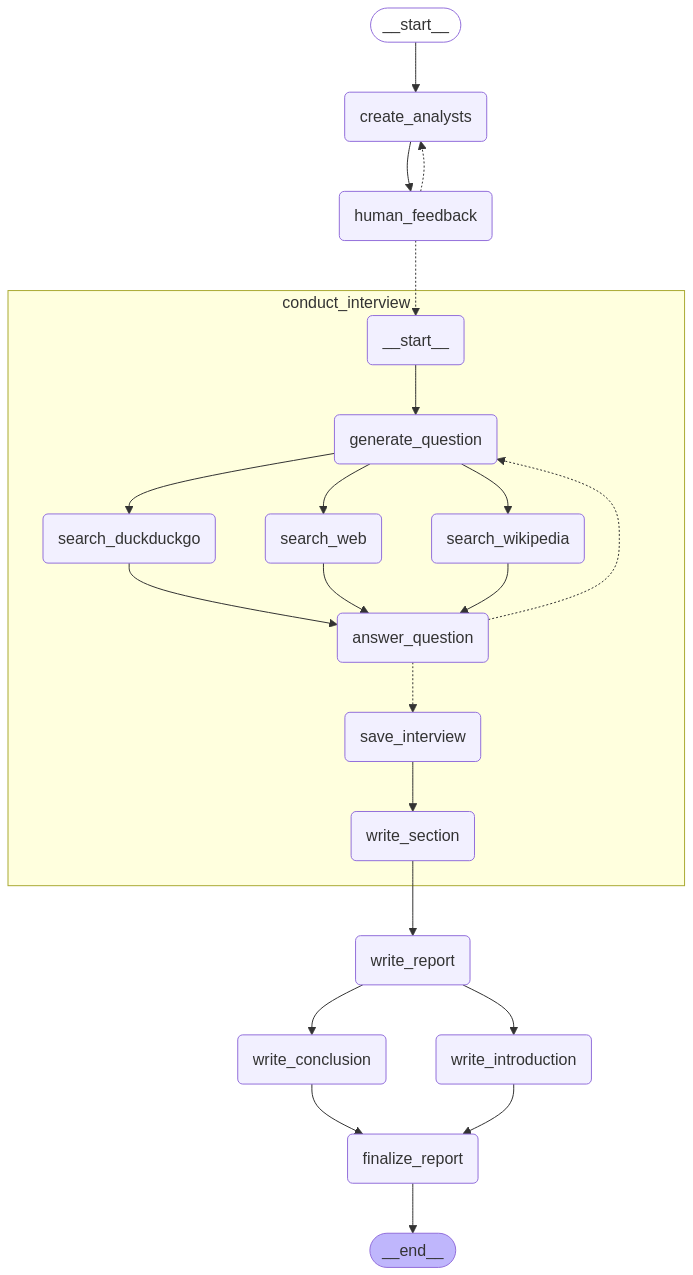

In [25]:
# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node(NodeName.CREATE_ANALYSTS, create_analysts)
builder.add_node(NodeName.HUMAN_FEEDBACK, human_feedback)
builder.add_node(NodeName.CONDUCT_INTERVIEW, interview_builder.compile())
builder.add_node(NodeName.WRITE_REPORT,write_report)
builder.add_node(NodeName.WRITE_INTRODUCTION,write_introduction)
builder.add_node(NodeName.WRITE_CONCLUSION,write_conclusion)
builder.add_node(NodeName.FINALIZE_REPORT,finalize_report)


builder.add_edge(START, NodeName.CREATE_ANALYSTS)
builder.add_edge(NodeName.CREATE_ANALYSTS, NodeName.HUMAN_FEEDBACK)
builder.add_conditional_edges(
        NodeName.HUMAN_FEEDBACK,
        initiate_all_interviews,
        [NodeName.CREATE_ANALYSTS, NodeName.CONDUCT_INTERVIEW]
    )
builder.add_edge(NodeName.CONDUCT_INTERVIEW, NodeName.WRITE_REPORT)
builder.add_edge(NodeName.WRITE_REPORT, NodeName.WRITE_INTRODUCTION)
builder.add_edge(NodeName.WRITE_REPORT, NodeName.WRITE_CONCLUSION)
builder.add_edge([NodeName.WRITE_INTRODUCTION, NodeName.WRITE_CONCLUSION], NodeName.FINALIZE_REPORT)
builder.add_edge(NodeName.FINALIZE_REPORT, END)

# Interview 
memory = MemorySaver()
final_graph = builder.compile(checkpointer=memory).with_config(run_name="Write Report")
display(Image(final_graph.get_graph(xray=1).draw_mermaid_png()))

In [140]:
max_analysts = 3 
topic = "Best NYC restaurants"
thread = {"configurable": {"thread_id": "5"}}

# final_graph.invoke({"topic": topic}, thread)

final_graph.invoke({"topic": topic},
        thread,
        stream_mode="updates"
    )

while final_graph.get_state(thread).next: #need while loop if there is feedback
        graph_state = final_graph.get_state(thread)
        interrupt_value = graph_state.tasks[0].interrupts[0].value

        # Occasionally, the previous print statement is not visible in the console.
        sleep(0.5)

        human_feedback_text = input(interrupt_value) #input stored here
        print(f"\nAgent Response: {human_feedback_text}\n\n")
        final_graph.invoke(Command(resume=human_feedback_text), config=thread)


analysts=[Analyst(name='Culinary Critic Clara', role='Food Critic', description="Clara focuses on reviewing the culinary aspects of NYC restaurants. Her main concern is the quality of the dishes, the creativity of the menu, and how well the restaurant executes its culinary vision. She is motivated by finding hidden gems and providing her audience with authentic, in-depth reviews of the city's top dining experiences."), Analyst(name='Atmosphere Analyst Alex', role='Restaurant Experience Evaluator', description="Alex evaluates the overall dining experience at NYC restaurants, focusing on the atmosphere, decor, service, and ambiance. His concerns are how these elements enhance or detract from the dining experience. Alex is driven by the desire to help diners find the perfect setting for various occasions, whether it's a romantic dinner or a lively brunch with friends."), Analyst(name='Budget-Friendly Brenda', role='Affordable Dining Specialist', description="Brenda specializes in finding 

Please input any feedback for the analysts:  



Agent Response: 


human feedback: 
initializing interviews
[Analyst(name='Culinary Critic Clara', role='Food Critic', description="Clara focuses on reviewing the culinary aspects of NYC restaurants. Her main concern is the quality of the dishes, the creativity of the menu, and how well the restaurant executes its culinary vision. She is motivated by finding hidden gems and providing her audience with authentic, in-depth reviews of the city's top dining experiences."), Analyst(name='Atmosphere Analyst Alex', role='Restaurant Experience Evaluator', description="Alex evaluates the overall dining experience at NYC restaurants, focusing on the atmosphere, decor, service, and ambiance. His concerns are how these elements enhance or detract from the dining experience. Alex is driven by the desire to help diners find the perfect setting for various occasions, whether it's a romantic dinner or a lively brunch with friends."), Analyst(name='Budget-Friendly Brenda', role='Affordable Dining Spec

In [142]:
Markdown(final_graph.get_state(thread).values['final_report'])

# Best NYC Restaurants: A Culinary Odyssey

## Introduction

New York City, renowned for its vibrant and diverse culinary landscape, offers an unparalleled gastronomic journey. This report delves into the city's dynamic dining scene, where innovation and diversity converge to create unforgettable experiences. From emerging restaurants pushing culinary boundaries with unique fusions and high-quality dishes, to the importance of ambiance in enhancing the dining experience, NYC's eateries set global standards. Additionally, the report explores the city's commitment to affordability, with neighborhoods like Chinatown and Queens offering budget-friendly yet authentic flavors. Join us as we uncover the culinary gems that make NYC a hub for food enthusiasts worldwide.

---



New York City's culinary landscape is a vibrant tapestry that encompasses a wide array of dining experiences, reflecting the city's diverse cultural influences and innovative spirit. The integration of creativity, ambiance, and affordability into NYC's dining scene solidifies its reputation as a global gastronomic hub.

A central theme in the city's culinary narrative is the emergence of new restaurants that push the boundaries of creativity and quality. Establishments like Figure Eight integrate Chinese-American elements with lower Atlantic coast flavors, creating standout dishes such as their renowned seafood tower [1]. Similarly, a bistro in Fort Greene, helmed by culinary titans Gabriel Stulman and April Bloomfield, offers a seasonally influenced menu that has captured the attention of diners with items like chilled martinis and a perfectly executed roast chicken [1]. In Williamsburg, Dhamaka presents a Cantonese-American fusion menu, where inventive dishes like a bean curd twist on cacio e pepe and an MSG Martini showcase a commitment to excellence [1].

The ambiance of NYC's restaurants is equally significant, as the atmosphere often elevates the dining experience. The strategic use of noise, decor, and colors can influence diner behavior and preferences. Establishments may intentionally create a lively environment to encourage quick table turnover or, conversely, opt for a relaxed setting with soft lighting to invite leisurely dining [1][2]. Thematic decor, such as nautical elements in seafood restaurants, can enhance the overall dining experience by influencing diners' choices [3]. Service quality also plays a crucial role, with attentive and friendly staff contributing to a positive ambiance that ensures customer satisfaction [5].

Affordability remains a key consideration for many diners, and NYC does not disappoint in offering budget-friendly yet high-quality options. Chinatown, particularly around Canal and Mott streets, is celebrated for its affordable Chinese cuisine [1]. Diverse neighborhoods such as Queens provide authentic and inexpensive dining experiences, reflecting the city's rich immigrant culture [2][5]. Street food, local markets, and grab-and-go options like Los Tacos No. 1 and Joe’s Pizza offer delicious meals without the hefty price tag [6][7]. Additionally, eateries embracing creative and fusion cuisines, such as Wahizza's Rabo pizza, demonstrate NYC's innovative culinary landscape at a low cost [4].

These insights collectively highlight NYC's dynamic culinary scene, where the fusion of diverse cultural influences, innovative dining concepts, and varied price points create a rich tapestry of gastronomic experiences. Whether seeking a high-end meal, the perfect dining ambiance, or an affordable culinary adventure, NYC offers something for every palate and occasion.



---

## Conclusion

New York City's culinary scene is a vibrant reflection of its rich cultural tapestry, innovation, and accessibility. The city's new restaurants push the boundaries of flavor and creativity, with establishments like Figure Eight and Dhamaka leading the charge with their inventive fusion dishes. Ambiance plays a crucial role in enhancing the dining experience, with strategic decor and service quality shaping diner satisfaction. Despite its reputation for high costs, NYC offers a plethora of affordable dining options, from Chinatown's budget-friendly fare to innovative street food. Collectively, these elements make NYC a global gastronomic hotspot that caters to diverse tastes and budgets.

## Sources


[1] https://www.timeout.com/newyork/restaurants/100-best-new-york-restaurants  
[2] https://www.nytimes.com/interactive/2024/dining/best-nyc-restaurants.html  
[3] https://www.theinfatuation.com/new-york/guides/best-restaurants-nyc  
[4] https://flavourjournal.biomedcentral.com/articles/10.1186/2044-7248-3-9  
[5] https://www.psychologytoday.com/us/blog/out-of-the-ooze/201704/the-ambience-of-a-restaurant-controls-what-we-eat-and-drink  
[6] https://www.cuboh.com/blog/restaurant-decor  
[7] https://observer.com/2018/01/my-terrible-meal-at-salt-baes-nusr-et-nyc-restaurant-review/  
[8] https://www.quora.com/What-are-the-best-budget-restaurants-in-NYC-if-youre-there-for-five-days  
[9] https://www.reddit.com/r/FoodNYC/comments/1djv36c/best_food_on_a_budget_in_nyc/  
[10] https://ny.eater.com/maps/best-affordable-restaurants-nyc-cheap-food-new-york-city  
[11] https://gothamist.com/arts-entertainment/10-of-the-best-low-budget-meals-in-new-york-city-that-are-worth-the-journey  
[12] https://www.reddit.com/r/FoodNYC/comments/1dmv02u/recommendations_for_foodies_visiting_nyc_on_a/  
[13] https://davidsbeenhere.com/2024/08/10/how-to-eat-in-new-york-on-a-budget/  
[14] https://ultimatefoodtours.com/blog/eat-in-nyc-on-a-budge

In [141]:
final_graph.get_state(thread).values['final_report']

"# Best NYC Restaurants: A Culinary Odyssey\n\n## Introduction\n\nNew York City, renowned for its vibrant and diverse culinary landscape, offers an unparalleled gastronomic journey. This report delves into the city's dynamic dining scene, where innovation and diversity converge to create unforgettable experiences. From emerging restaurants pushing culinary boundaries with unique fusions and high-quality dishes, to the importance of ambiance in enhancing the dining experience, NYC's eateries set global standards. Additionally, the report explores the city's commitment to affordability, with neighborhoods like Chinatown and Queens offering budget-friendly yet authentic flavors. Join us as we uncover the culinary gems that make NYC a hub for food enthusiasts worldwide.\n\n---\n\n\n\nNew York City's culinary landscape is a vibrant tapestry that encompasses a wide array of dining experiences, reflecting the city's diverse cultural influences and innovative spirit. The integration of creativ

In [136]:
final_graph.get_state(thread).values['introduction'].content

"# NYC's Culinary Excellence: A Tapestry of Tradition and Innovation\n\n## Introduction\n\nNew York City, a global culinary capital, offers an unparalleled dining experience that reflects its cultural diversity and innovative spirit. This report delves into the city's vibrant culinary scene, highlighting restaurants renowned for their authenticity, such as Bolivian Llama Party and La Savane, which preserve traditional recipes. We explore the rise of experimental cuisine, where chefs push boundaries with sustainable practices. The importance of ambiance and service is showcased in venues like Enoteca Harlem and Da' Franco & Tony's Ristorante. Furthermore, we examine how social media influences dining experiences, engaging diverse audiences and enhancing NYC's culinary allure."

In [137]:
final_graph.get_state(thread).values['content']

"## Insights\n\nNew York City's culinary landscape is a rich tapestry of authenticity, innovation, and dynamic dining experiences. The city's reputation as a global culinary capital is underpinned by its diverse offerings that reflect the cultural mosaic of its population. Restaurants in NYC are celebrated for their commitment to authenticity, with establishments like Bolivian Llama Party and La Savane honoring traditional recipes and ingredients [1]. This dedication to preserving culinary heritage is complemented by a thriving scene of experimental cuisine, where chefs are redefining traditional flavors with sustainable and innovative practices [2].\n\nThe dining experience in NYC extends beyond the plate, with exceptional service, ambiance, and customer satisfaction being crucial elements. Restaurants such as Enoteca Harlem and Da' Franco & Tony's Ristorante are noted for their outstanding service, ensuring that diners feel valued [1]. The ambiance of a restaurant, thoughtfully desig

In [37]:
!pip show pydantic

Name: pydantic
Version: 2.10.6
Summary: Data validation using Python type hints
Home-page: 
Author: 
Author-email: Samuel Colvin <s@muelcolvin.com>, Eric Jolibois <em.jolibois@gmail.com>, Hasan Ramezani <hasan.r67@gmail.com>, Adrian Garcia Badaracco <1755071+adriangb@users.noreply.github.com>, Terrence Dorsey <terry@pydantic.dev>, David Montague <david@pydantic.dev>, Serge Matveenko <lig@countzero.co>, Marcelo Trylesinski <marcelotryle@gmail.com>, Sydney Runkle <sydneymarierunkle@gmail.com>, David Hewitt <mail@davidhewitt.io>, Alex Hall <alex.mojaki@gmail.com>, Victorien Plot <contact@vctrn.dev>
License: 
Location: /Users/kassandramadulka/Downloads/notebook/lib/python3.10/site-packages
Requires: annotated-types, pydantic-core, typing-extensions
Required-by: langchain, langchain-core, langsmith, openai, pydantic-settings
